# Parcial 1 Data Mining For Big Data

Una técnica clásica para analizar un conjunto de documentos es calcular su indice TF-iDF. La idea detrás de este índice es saber cuales son las palabras relevantes en un documento. La intuición nace en hallar las palabras con mucha frecuencia pero que aparecen en pocos textos. De manera más específica el indice Tf-idf para un par palabra i documento j está dado por:

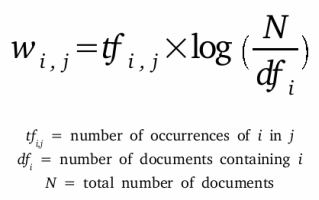

Encuentre dichos coeficientes para las parejas palabra documento, dónde, documento es una linea de un archivo de texto. Puede usar o no las porciones de código de los notebooks hechos en clase. La única condición es que use al menos un map y un reduce (no es necesario usar Hadoop y/o Spark, sólo los conceptos de Mappers y Reducers para el cálculo).

Para cada paso principal **incluya una celda de texto o comentario en el código explicando por qué tomó la decisión de hacer el cálculo de esa manera** (esta explicación con sus propias palabras es obligatoria y vale la mitad del resultado del parcial).


## Entorno de ejecución.

Este ejercicio se solucionó de manera local utilizando `pipenv` en Windows Subsystem for Linux (WSL). Para ejecutar el Notebook siga las indicaciones del archivo `README`.

## Datos.

Los datos se agregaron manualmente en el repositorio del proyecto. Si va a ejecutar en google colab, puede comentar la celda de cargue de los datos local y descomentar las celdas de carga de datos desde drive.

In [4]:
## Mostrar las 10 primeras filas del libro
!head -10 pg100.txt

The Project Gutenberg EBook of The Complete Works of William Shakespeare, by
William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org

** This is a COPYRIGHTED Project Gutenberg eBook, Details Below **
**     Please follow the copyright guidelines in this file.     **


In [5]:
### Datos con ejecución en colab.  ------->  Descomente si ejecuta en colab.
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials#

## Authenticate and create the PyDrive client
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)#

#id='1SE6k_0YukzGd5wK-E4i6mG83nydlfvSa'
#downloaded = drive.CreateFile({'id': id})
## Documento principal
#downloaded.GetContentFile('pg100.txt')

## Solución

Para resolver este problema se va a fragmentar el ebook `The Complete Works of William Shakespeare, by
William Shakespeare` por línea de texto, cada línea representará un Documento.

Luego, se utilizará MapReduce para calcular el índice `TF-iDF` para cada palabra. No se aplicarán transformaciones al texto ni se van a remover stop words.

Se va a realizar el proceso simulando un escenario con `pyspark` y finalmente se formateará la versión de `pyspark en entorno productivo`.

### Librerías

In [6]:
from pyspark.sql import SparkSession
from operator import add
from math import log

### 2. Calculando índice TF-iDF con MapReduce

#### `PySpark`

In [7]:
text_file="pg100.txt"

In [8]:
from pyspark.sql import SparkSession
from math import log
from operator import add

# Toma una sesión de Spark existente y en caso de que no exista la crea
spark = SparkSession.builder.appName('TF-IDF').getOrCreate()

# Leemos el archivo en un RDD donde cada línea es un documento
lines = spark.read.text('pg100.txt').rdd.map(lambda r: r[0])
# * Explicación de pasos:
# 1. spark.read.text() lee archivos a la sesión de spark en formato texto
# 2. `.rdd` convierte el archivo de texto en un Resilent Distributed Dataset, separandolo por cada línea
# 3. `.map` mapea el rdd por su único elemento (r[0]) que corresponde a todo el texto de la línea


# Calcular el número total de documentos (líneas)
total_documents = lines.count()


# Calculamor la frecuencia de términos (TF) de cada palabra en cada documento
tf = lines.zipWithIndex() \
          .flatMap(lambda x: [((word.lower(), x[1]), 1) for word in x[0].split()]) \
          .reduceByKey(add) \
          .map(lambda x: (x[0][0], (x[0][1], x[1]))) # ((palabra, (id_documento, tf)))
# * Explicación de pasos:
#  1. Se debe mapear cada documento en palabras, id de documento y frecuencia -> ((palabra, id_documento), 1).
#     zipWithIndex() crea un nuevo RDD donde cada elemento `x` es una tupla de (documento (x[0]), id_documento (x[1]))
#  2. flatMap() se utiliza para mapear la tupla anterior en ((palabra, id_documento), frecuencia=1) -> x[0].split() crea la lista de palabras de c/doc
#  3. reduceByKey() agrupa todas las tuplas por (palabra, id_documento) y suma la frecuencia -> ((palabra, id_documento) (X[0]), suma (X[1]))
#  4. map() mapea los resultados en ((palabra, (id_documento, tf))) donde cada palabra en id_documento aparece solo una vez con su respectiva suma de frecuencia


# Calcular la frecuencia de documentos (DF) para cada palabra
df = tf.map(lambda x: (x[0], 1)) \
       .reduceByKey(add)
# * Explicación de pasos:
#  1. Se utiliza .map() para mapear cada tupla de tf ((palabra, (id_documento, tf))) en (palabra (x[0]), frecuencia=1)
#  2. reduceByKey() agrupa todas las tuplas por palabra[0] y suma la document frequency -> (palabra, DF)


# Calcular la frecuencia de documentos inversa (IDF) mapeando cada palabra con su iDF -> (palabra, iDF)
idf = df.map(lambda x: (x[0], log(total_documents / float(x[1]))))  
# * Explicación de pasos:
#  1. Se utiliza .map() para mapear cada tupla de DF (palabra, DF) en (palabra, iDF), se debe llevar a float DF para realizar la operación


# Calcular TF-IDF
tf_idf = tf.join(idf).map(lambda x: ((x[0], x[1][0][0]), x[1][0][1] * x[1][1]))
# * Explicación de pasos:
#  Estructura RDDs = `tf`-> (palabra, (id_documento, tf))  
#                   `idf`-> (palabra, idf)  
#  1. tf.join(idf) realiza un inner join entre `tf` e `idf` usando como llave "palabra" -> (palabra, ((id_documento, tf), idf)
#  2. map() mapea el resultado de la tupla anterior como (palabra, id_documento), TF-iDF)


# Recolectamos los resultados de tf_idf
results = tf_idf.collect()

# Detenemos la sesión de Spark
spark.stop()

your 131072x1 screen size is bogus. expect trouble
24/03/03 19:01:49 WARN Utils: Your hostname, LAPTOP-VGV787K4 resolves to a loopback address: 127.0.1.1; using 172.23.1.52 instead (on interface eth0)
24/03/03 19:01:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/03 19:01:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
results[:20]

[(('of', 0), 3.980212471719005),
 (('of', 26), 1.9901062358595025),
 (('of', 40), 3.980212471719005),
 (('of', 42), 1.9901062358595025),
 (('of', 50), 3.980212471719005),
 (('of', 62), 3.980212471719005),
 (('of', 64), 1.9901062358595025),
 (('of', 76), 1.9901062358595025),
 (('of', 84), 1.9901062358595025),
 (('of', 92), 1.9901062358595025),
 (('of', 106), 1.9901062358595025),
 (('of', 108), 1.9901062358595025),
 (('of', 112), 1.9901062358595025),
 (('of', 122), 1.9901062358595025),
 (('of', 132), 1.9901062358595025),
 (('of', 134), 1.9901062358595025),
 (('of', 136), 1.9901062358595025),
 (('of', 144), 1.9901062358595025),
 (('of', 148), 1.9901062358595025),
 (('of', 202), 1.9901062358595025)]

#### `PySpark en entorno productivo`

In [14]:
%%writefile TF-iDF.py
"""TF-iDF.py"""

#Librerías
from pyspark.sql import SparkSession
from math import log
from operator import add

#Nombre librerías
text_file="pg100.txt"


spark = SparkSession.builder.appName('TF-IDF').getOrCreate()

lines = spark.read.text(text_file).rdd.map(lambda r: r[0])

total_documents = lines.count()

tf = lines.zipWithIndex() \
          .flatMap(lambda x: [((word.lower(), x[1]), 1) for word in x[0].split()]) \
          .reduceByKey(add) \
          .map(lambda x: (x[0][0], (x[0][1], x[1]))) # ((palabra, (id_documento, tf)))

df = tf.map(lambda x: (x[0], 1)) \
       .reduceByKey(add)

idf = df.map(lambda x: (x[0], log(total_documents / float(x[1]))))  

tf_idf = tf.join(idf).map(lambda x: ((x[0], x[1][0][0]), x[1][0][1] * x[1][1]))

results_tfidf = tf_idf.collect()

# Convertimos los resultados en strings y los escribimos en un archivo
with open("results_tfidf.txt", "w") as file:
    for result in results_tfidf:
        # Convertimos cada tupla a string
        line = str(result) + "\n"
        file.write(line)

# Detenemos la sesión de Spark
spark.stop()


Overwriting TF-iDF.py


In [16]:
!spark-submit TF-iDF.py 2>log_tf_idf.txt  ## Se guardan los logs en el archivo log_tf_idf.txt para retornar solo el resultado del .py

In [17]:
# Leer los resultados desde el archivo
with open("results_tfidf.txt", "r") as file:
    results = file.readlines()

# Convertir los resultados a la forma deseada si es necesario y mostrar los primeros 10
for result in results[:10]:
    print(result.strip())

(('of', 0), 3.980212471719005)
(('of', 26), 1.9901062358595025)
(('of', 40), 3.980212471719005)
(('of', 42), 1.9901062358595025)
(('of', 50), 3.980212471719005)
(('of', 62), 3.980212471719005)
(('of', 64), 1.9901062358595025)
(('of', 76), 1.9901062358595025)
(('of', 84), 1.9901062358595025)
(('of', 92), 1.9901062358595025)
